# Using autoenconder for anomaly detection

### The [dataset](https://www.kaggle.com/mlg-ulb/creditcardfraud) *creditcard* comes from kaggle.

The ideia is to feed only normal transactions to the autoencoder so it learns to reproduce the data with high fidelity. As a consequence, if a fraud transaction is distinct from the normal ones, the autoenconder will have trouble reproducing it and the subsequent reconstruction loss will be high.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from sklearn.manifold import TSNE
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

## Loading the dataset

In [2]:
path_to_data = os.getcwd().replace("\\", "/") + "/creditcard.csv"
credit_card_df = pd.read_csv(path_to_data)
credit_card_df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


## Information about the dataset

In [3]:
print(f"This dataset has {credit_card_df.shape[0]} rows and {credit_card_df.shape[1]} columns")

This dataset has 284807 rows and 31 columns


In [4]:
credit_card_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

### No null values

In [5]:
null_values = credit_card_df.isnull().sum()
print(null_values[null_values > 0])

Series([], dtype: int64)


## Taking a look at the Class column

### Only 0.17% of the examples are fraud examples

In [6]:
class_df = credit_card_df.groupby("Class").Class.count().reset_index(name = "nº of examples").rename(index = {0: "normal", 1:"fraud"})
class_df["percentage"] = [(class_df.iloc[0, 1] / credit_card_df.shape[0]) * 100, (class_df.iloc[1, 1] / credit_card_df.shape[0]) * 100]
class_df

,Class,nº of examples,percentage
normal,0,284315,99.827251
fraud,1,492,0.172749


## Preprocessing of the dataset columns

### The Time column is in seconds so we will change it to days

In [7]:
credit_card_df["Time"] = credit_card_df["Time"].apply(lambda t: (t / 3600) % 24)

### splitting the fraud and normal transactions

In [8]:
normal_transactions = credit_card_df[credit_card_df["Class"] == 0]
fraud_transactions = credit_card_df[credit_card_df["Class"] == 1]

In [9]:
print(f"""Normal transactions data is (row, columns): {normal_transactions.shape}
Fraud transactions data is (row, columns): {fraud_transactions.shape}""")

Normal transactions data is (row, columns): (284315, 31)
Fraud transactions data is (row, columns): (492, 31)


### There are too many normal transactions examples so we are going to use only a reduced number of them

In [10]:
reduced_data = normal_transactions.sample(5000).append(fraud_transactions).reset_index(drop = True)
print(f"The reduced data has {reduced_data.shape[0]} rows and {reduced_data.shape[1]} columns")

The reduced data has 5492 rows and 31 columns


## Visualize the data with t-SNE

### TNSE (t-distributed Stochastic Neighbor Embedding) is one of the dimensionality reduction method other than PCA.

Going to create a function because this code will be used again after the autoencoder is trained

In [11]:
def dimensionality_plot(X, y):
    # Initializing TSNE object with 2 principal components
    tsne = TSNE(n_components = 2, random_state = 42)
    
    # Fitting the data
    X_trans = tsne.fit_transform(X)
    
    plt.figure(figsize=(12, 8))
    
    plt.scatter(X_trans[np.where(y == 0), 0], X_trans[np.where(y==0), 1], marker = 'o', color = 'g', linewidth = 1, alpha = 0.8, label = 'Normal')
    plt.scatter(X_trans[np.where(y == 1), 0], X_trans[np.where(y==1), 1], marker = 'o', color= 'k', linewidth = 1, alpha = 0.8, label = 'Fraud')
    
    plt.legend(loc = 'best')
    plt.show()

### Separating the reduced dataset into features and labels

In [12]:
X = reduced_data.drop(["Class"], axis = 1)
y = reduced_data["Class"]
print(f"Shape of features: {X.shape} and labels: {y.shape}")

Shape of features: (5492, 30) and labels: (5492,)


c:\Users\Legion\Desktop\anomaly-detection-autoencoder\venv\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
c:\Users\Legion\Desktop\anomaly-detection-autoencoder\venv\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


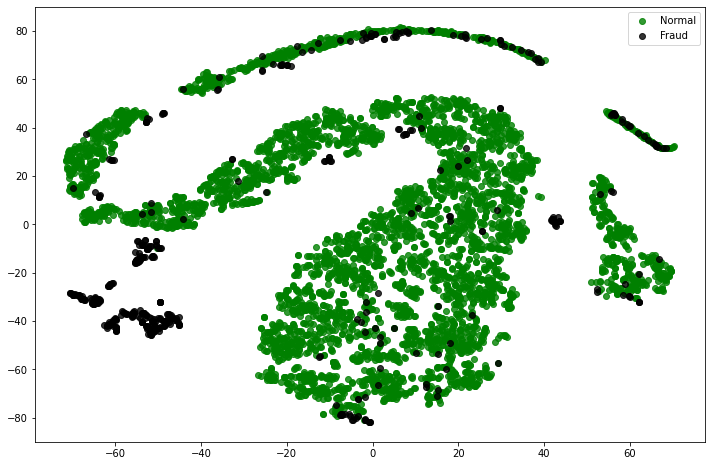

In [13]:
dimensionality_plot(X, y)

## Normalize and Scale the features

In [14]:
scaler = RobustScaler().fit_transform(X)

X_scaled_normal = scaler[y == 0]
X_scaled_fraud = scaler[y == 1]

## Building the Autoenconder

In [15]:
input_size = X.shape[1]
print(f"Shape of the input data: {input_size}")

Shape of the input data: 30


In [16]:
## Encoder
encoder_input = keras.layers.Input(shape = (input_size,))
l = keras.layers.Dense(100, activation = "tanh")(encoder_input)
l = keras.layers.Dense(50, activation = "tanh")(l)
l = keras.layers.Dense(25, activation = "tanh")(l)
l = keras.layers.Dense(12, activation = "tanh")(l)
encoder_output = keras.layers.Dense(6, activation = "relu", name = "bottleneck")(l)
## Decoder
decoder_input = keras.layers.Dense(12, activation = "tanh")(encoder_output)
l = keras.layers.Dense(25, activation = "tanh")(decoder_input)
l = keras.layers.Dense(50, activation = "tanh")(l)
l = keras.layers.Dense(100, activation = "tanh")(l)
decoder_output = keras.layers.Dense(input_size, activation = "relu")(l)
## Autoencoder model
autoencoder = keras.Model(encoder_input, decoder_output, name = "autoencoder")
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 30)]              0         
_________________________________________________________________
dense (Dense)                (None, 100)               3100      
_________________________________________________________________
dense_1 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_2 (Dense)              (None, 25)                1275      
_________________________________________________________________
dense_3 (Dense)              (None, 12)                312       
_________________________________________________________________
bottleneck (Dense)           (None, 6)                 78        
_________________________________________________________________
dense_4 (Dense)              (None, 12)                

In [17]:
autoencoder.compile(optimizer = "adam", loss = "mse")
history = autoencoder.fit(X_scaled_normal, X_scaled_normal, validation_split = 0.2, epochs = 20, batch_size = 32, shuffle = True)

Epoch 1/20
125/125 [==============================] - 1s 3ms/step - loss: 1.4480 - val_loss: 1.3363
Epoch 2/20
125/125 [==============================] - 0s 1ms/step - loss: 1.2964 - val_loss: 1.2777
Epoch 3/20
125/125 [==============================] - 0s 1ms/step - loss: 1.2448 - val_loss: 1.2377
Epoch 4/20
125/125 [==============================] - 0s 1ms/step - loss: 1.2010 - val_loss: 1.1987
Epoch 5/20
125/125 [==============================] - 0s 1ms/step - loss: 1.1694 - val_loss: 1.1875
Epoch 6/20
125/125 [==============================] - 0s 1ms/step - loss: 1.1459 - val_loss: 1.1659
Epoch 7/20
125/125 [==============================] - 0s 1ms/step - loss: 1.1244 - val_loss: 1.1398
Epoch 8/20
125/125 [==============================] - 0s 1ms/step - loss: 1.0989 - val_loss: 1.1215
Epoch 9/20
125/125 [==============================] - 0s 1ms/step - loss: 1.0850 - val_loss: 1.1013
Epoch 10/20
125/125 [==============================] - 0s 1ms/step - loss: 1.0664 - val_loss: 1.0988

## Encoded data

In [19]:
encoder = keras.Model(encoder_input, encoder_output, name = "encoder")

In [20]:
normal_transactions_encoder = encoder.predict(X_scaled_normal)
fraud_transactions_encoder = encoder.predict(X_scaled_fraud)

In [21]:
encoded_X = np.append(normal_transactions_encoder, fraud_transactions_encoder, axis = 0)
y_normal = np.zeros(normal_transactions_encoder.shape[0])
y_fraud = np.ones(fraud_transactions_encoder.shape[0])
encoded_y = np.append(y_normal, y_fraud, axis = 0)

c:\Users\Legion\Desktop\anomaly-detection-autoencoder\venv\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
c:\Users\Legion\Desktop\anomaly-detection-autoencoder\venv\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


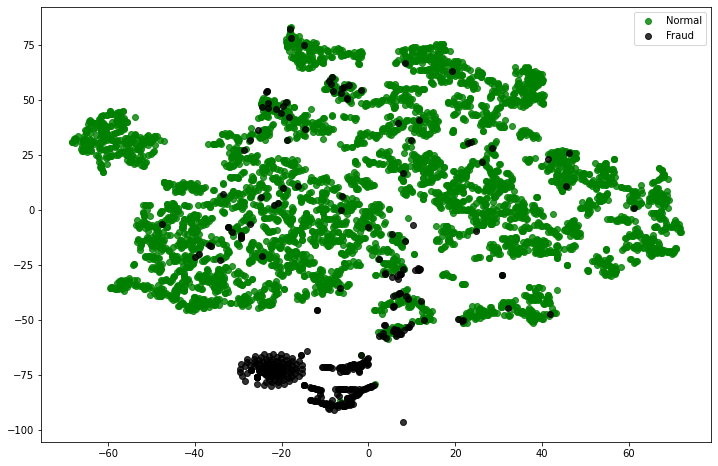

In [22]:
dimensionality_plot(encoded_X, encoded_y)

## Conclusions

### We can observe that the encoded fraud transcations have been moved towards one cluster, whereas there are only a few fraud transactions among the normal transactions.
### Now it would be possible to use a linear classifier to indentify the fraud and normal transactions

### let´s first divide the data

In [23]:
X_train_encoded, X_test_encoded, y_train_encoded, y_test_encoded = train_test_split(encoded_X, encoded_y, test_size = 0.3, random_state = 42)

### Linear Classifier

In [30]:
lr_clf = LogisticRegression(random_state = 42)
lr_clf.fit(X_train_encoded, y_train_encoded)
predictions = lr_clf.predict(X_test_encoded)

print(classification_report(y_test_encoded, predictions))

              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99      1494
         1.0       0.95      0.76      0.84       154

    accuracy                           0.97      1648
   macro avg       0.96      0.88      0.92      1648
weighted avg       0.97      0.97      0.97      1648



### As we can see a 97% accuracy from a linear classifier